In [2]:
import os
import numpy as np

from metods import *
from matplotlib import pyplot as plt
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from keras_unet.models import custom_unet

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [3]:
#Genel değişkenleri oluşturuyoruz.
IMG_HEIGHT = 128
IMG_WIDTH = 128

image_path = "C:\\Users\\ugur_\\Python Projects\\DATA\\Lung Segmentation\\CXR_png\\"
mask_path = "C:\\Users\\ugur_\\Python Projects\\DATA\Lung Segmentation\\masks\\"

images = os.listdir(image_path)
mask = os.listdir(mask_path)

print(len(images), len(mask))

800 704


In [4]:
#Maskesi olmayan görselleri filtreliyoruz.
mask2 = [fName.split(".png")[0] for fName in mask]
image_file_name = [fName.split("_mask")[0] for fName in mask2]
print(len(image_file_name), len(mask))

704 704


In [5]:
#Filtre sonucunda kaç görsel kaldığını kontrol ediyoruz.
check = [i for i in mask if "mask" in i]
print(len(check))

566


In [6]:
#X ve Y değişkenlerimizi oluşturup verilerimizi yüklüyoruz.
x = np.zeros((len(mask), IMG_HEIGHT, IMG_WIDTH))
y = np.zeros((len(mask), IMG_HEIGHT, IMG_WIDTH))

for i, img_id in enumerate(image_file_name):
    
    file_path = image_path  + img_id + ".png"
    img = readImages(file_path,  IMG_HEIGHT = 128, IMG_WIDTH = 128, is_gray=0)
    x[i] = img


for i, img_id in enumerate(mask):
    
    file_path = mask_path  + img_id 
    img = readImages(file_path,  IMG_HEIGHT = 128, IMG_WIDTH = 128, is_gray=0)
    y[i] = img

In [7]:
#Train & Test split işlemini gerçekleştiriyoruz.
X_train, X_test, y_train_m, y_test_m = train_test_split(x, y, test_size=0.2, random_state=123)

#Aynalama işlemi uyguluyoruz.
x2 = np.flip(X_train , axis = 2)
y2 = np.flip(y_train_m , axis = 2)

X_train = np.append(X_train, x2,axis=0)
y_train_m = np.append(y_train_m, y2,axis=0)

(1126, 128, 128) (1126, 128, 128)


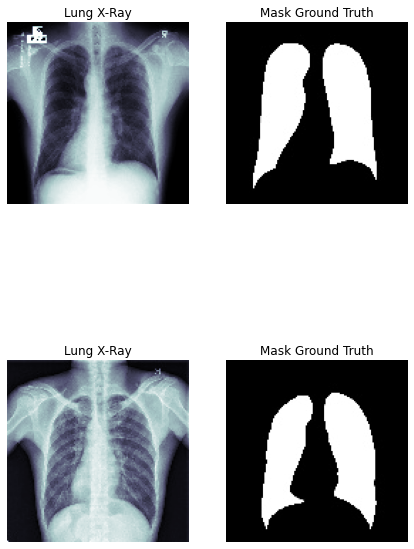

In [12]:
print(X_train.shape,y_train_m.shape)
showRandomPredict(X_train, y_train_m, y_train_m, 2)

In [14]:
#Özelleştirilmiş U-Net modelimizi ve callbacklerimizi tanımlıyoruz.

model = custom_unet(
    (128, 128, 1),
    use_batch_norm=True,
    num_classes=1,
    filters=64,
    dropout=0.2,
    output_activation='sigmoid',)

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=4, verbose=1, min_delta=1e-4),
    ModelCheckpoint('model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'),]

model.compile(
    optimizer=Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy'],)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 576         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
spatial_dropout2d (SpatialDropo (None, 128, 128, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [16]:
#Verimize normalizasyon işlemi uyguluyoruz.

y_test_m2 = (y_test_m/255.> .5).astype(int)
y_train_m2 = (y_train_m/255.> .5).astype(int)

In [18]:
#Eğitimi başlatıyoruz.

h = model.fit(
    X_train/255., y_train_m2,   
    callbacks=callbacks,
    validation_data=(X_test/255., y_test_m2),
    epochs=15, batch_size=20,
)

Epoch 1/15
57/57 [==============================] - 9s 154ms/step - loss: 0.0304 - accuracy: 0.9873 - val_loss: 0.0560 - val_accuracy: 0.9820

Epoch 00001: val_accuracy did not improve from 0.98305
Epoch 2/15
57/57 [==============================] - 9s 154ms/step - loss: 0.0296 - accuracy: 0.9877 - val_loss: 0.0547 - val_accuracy: 0.9824

Epoch 00002: val_accuracy did not improve from 0.98305
Epoch 3/15
57/57 [==============================] - 9s 155ms/step - loss: 0.0295 - accuracy: 0.9876 - val_loss: 0.0564 - val_accuracy: 0.9820

Epoch 00003: val_accuracy did not improve from 0.98305
Epoch 4/15
57/57 [==============================] - 9s 157ms/step - loss: 0.0291 - accuracy: 0.9878 - val_loss: 0.0575 - val_accuracy: 0.9819

Epoch 00004: val_accuracy did not improve from 0.98305
Epoch 5/15
57/57 [==============================] - 9s 165ms/step - loss: 0.0291 - accuracy: 0.9878 - val_loss: 0.0577 - val_accuracy: 0.9820

Epoch 00005: val_accuracy did not improve from 0.98305
Epoch 6/15

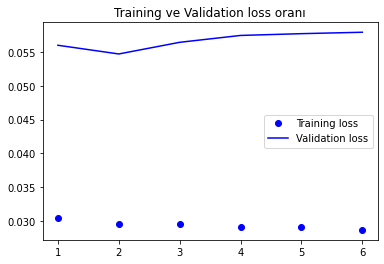

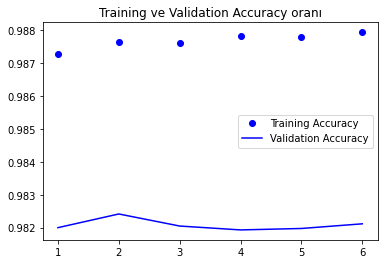

<Figure size 432x288 with 0 Axes>

In [20]:
#Eğitim sonuçlarını görselleştirip en iyi modeli yükleyerek tahmin yapıyoruz.

model = load_model("model.h5")

#Eğitim sonuçlarını grafiğe döküyoruz.
acc = h.history['accuracy']
val_acc = h.history['val_accuracy']
loss = h.history['loss']
val_loss = h.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training ve Validation loss oranı')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training ve Validation Accuracy oranı')
plt.legend()
plt.figure()

preds = model.predict(X_test/255.)*255


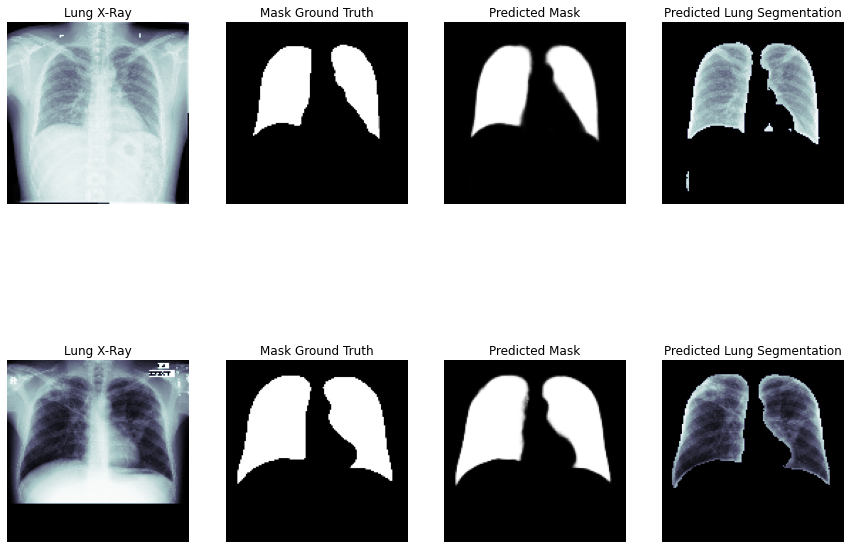

In [34]:
#Tahmin sonuçlarımızı görselleştiriyoruz.
showRandomPredict(X_test, y_test_m, preds, 2, True)

In [16]:
#Yeni callbackler tanımlayarak 2. eğitim adımına geçiyoruz.

callbacks = [
    ReduceLROnPlateau(monitor='loss', patience=3, verbose=1, factor=0.5, min_lr=0.00001),
    ModelCheckpoint('model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'),
]

h2 = model.fit(
    X_train/255., y_train_m2,
    validation_data=(X_test/255., y_test_m2),
    epochs=50, batch_size=16,
    shuffle=True,
    verbose=2,
    callbacks=callbacks
)

Epoch 1/50
71/71 - 20s - loss: 0.0474 - accuracy: 0.9813 - val_loss: 0.0579 - val_accuracy: 0.9802

Epoch 00001: val_accuracy improved from -inf to 0.98024, saving model to model.h5
Epoch 2/50
71/71 - 8s - loss: 0.0484 - accuracy: 0.9813 - val_loss: 0.0602 - val_accuracy: 0.9805

Epoch 00002: val_accuracy improved from 0.98024 to 0.98049, saving model to model.h5
Epoch 3/50
71/71 - 8s - loss: 0.0493 - accuracy: 0.9811 - val_loss: 0.0886 - val_accuracy: 0.9741

Epoch 00003: val_accuracy did not improve from 0.98049
Epoch 4/50
71/71 - 8s - loss: 0.0464 - accuracy: 0.9819 - val_loss: 0.0512 - val_accuracy: 0.9813

Epoch 00004: val_accuracy improved from 0.98049 to 0.98131, saving model to model.h5
Epoch 5/50
71/71 - 8s - loss: 0.0435 - accuracy: 0.9828 - val_loss: 0.0519 - val_accuracy: 0.9809

Epoch 00005: val_accuracy did not improve from 0.98131
Epoch 6/50
71/71 - 8s - loss: 0.0516 - accuracy: 0.9803 - val_loss: 0.4844 - val_accuracy: 0.9216

Epoch 00006: val_accuracy did not improve f

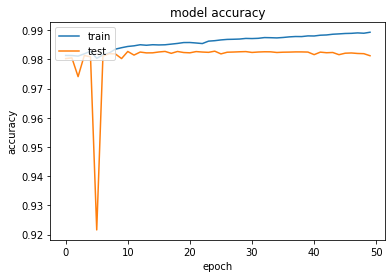

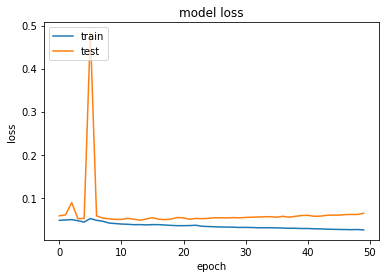

In [18]:
#Aynı görselleştirme işlemini tekrar uygulayıp eğitimi tamamlıyoruz.
model = load_model('model.h5')

plt.plot(h2.history['accuracy'])
plt.plot(h2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(h2.history['loss'])
plt.plot(h2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

losses = h2.history['loss']
accs = h2.history['accuracy']
val_losses = h2.history['val_loss']
val_accs = h2.history['val_accuracy']
epochs = len(losses)

In [1]:
#Son eğitimden sonra tekrar görselleştirme yapıyoruz.
showRandomPredict(X_test, y_test_m, preds, 3, True)

NameError: name 'showRandomPredict' is not defined